In [1]:
import torch, torch.nn as nn
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
import snntorch.functional as SF
from snntorch import surrogate
import tonic
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D    


from tonic import datasets, transforms

torch.autograd.set_detect_anomaly(True)

dt = 30000 # -> binning every 30ms
# ^^decrease this to increase temporal resolution (possible performance boost)

# encoding_dim = 100

transform = transforms.Compose(
            [
                # transforms.Downsample(spatial_factor=encoding_dim/700),
                transforms.CropTime(max=1e6), # all timestamp units in microseconds in Tonic -> 0.8s-1.2s samples in SHD -> crops to 1s
                transforms.ToFrame(
                    sensor_size=tonic.datasets.SHD.sensor_size,
                    time_window=dt, # -> 1s/30ms = 34 frames max
                    include_incomplete=True, # if not evenly divisible by dt, include the last incomplete frame
                ),
            ]
        )

trainset=datasets.SHD('data', transform=transform)
testset=datasets.SHD('data', transform=transform, train=False)

In [2]:
trainset.__dict__

{'location_on_system': 'data/SHD',
 'transform': Compose(
     CropTime(min=0, max=1000000.0)
     ToFrame(sensor_size=(700, 1, 1), time_window=30000, event_count=None, n_time_bins=None, n_event_bins=None, overlap=0, include_incomplete=True)
 ),
 'target_transform': None,
 'transforms': None,
 'data': [],
 'targets': [],
 'folder_name': '',
 'url': 'https://zenkelab.org/datasets/shd_train.h5.zip',
 'filename': 'shd_train.h5.zip',
 'file_md5': 'f3252aeb598ac776c1b526422d90eecb',
 'data_filename': 'shd_train.h5',
 'classes': array([b'zero', b'one', b'two', b'three', b'four', b'five', b'six',
        b'seven', b'eight', b'nine', b'null', b'eins', b'zwei', b'drei',
        b'vier', b'fuenf', b'sechs', b'sieben', b'acht', b'neun'],
       dtype='|S6'),
 '_speaker': array([ 2, 11,  0, ...,  0,  9,  6], dtype=uint16)}

In [3]:
dir(trainset)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_exists',
 '_folder_contains_at_least_n_files_of_type',
 '_is_file_present',
 '_speaker',
 'base_url',
 'classes',
 'data',
 'data_filename',
 'download',
 'dtype',
 'file_md5',
 'filename',
 'folder_name',
 'location_on_system',
 'ordering',
 'sensor_size',
 'speaker',
 'target_transform',
 'targets',
 'test_md5',
 'test_zip',
 'train_md5',
 'train_zip',
 'transform',
 'transforms',
 'url']

(27, 1, 700) 16
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0
  1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 2 1 0 0 0 1 0 1 1 1 0 2
  2 2 2 1 0 1 2 1 0 0 1 0 1 2 0 0 1 1 1 1 2 0 1 1 0 1 1 1 0 0 0 2 2 1 1 1
  1 1 2 2 1 0 2 0 2 2 0 1 1 1 1 3 2 1 4 1 2 3 1 1 2 3 4 3 1 1 1 2 3 1 2 1
  2 1 2 1 2 1 3 4 3 3 1 0 3 2 2 3 4 2 3 3 3 0 4 3 3 3 1 1 1 3 1 2 2 2 3 3
  1 2 4 2 3 1 0 3 2 3 1 3 6 2 1 1 0 2 2 1 4 1 1 3 2 2 3 1 3 1 0 0 1 2 2 1
  1 1 3 0 0 1 2 0 1 0 1 1 2 2 1 0 1 1 1 0 1 0 1 1 0 0 1 1 0 1 2 0 1 1 0 0
  2 2 2 2 0 2 2 2 0 1 1 3 0 1 0 2 2 3 0 0 1 2 2 0 1 2 1 0 1 2 3 2 2 0 2 0
  3 0 4 1 1 0 2 2 0 1 2 1 0 2 1 0 2 1 1 0 1 0 2 3 2 2 1 1 1 1 3 1 2 0 2 1
  1 2 1 1 1 1 1 2 0 3 1 0 1 0 0 2 2 4 1 2 1 2 0 2 2 1 3 4 3 1 3 1 2 1 3 1
  2 1 1 2 2 1 3 3 0 1 

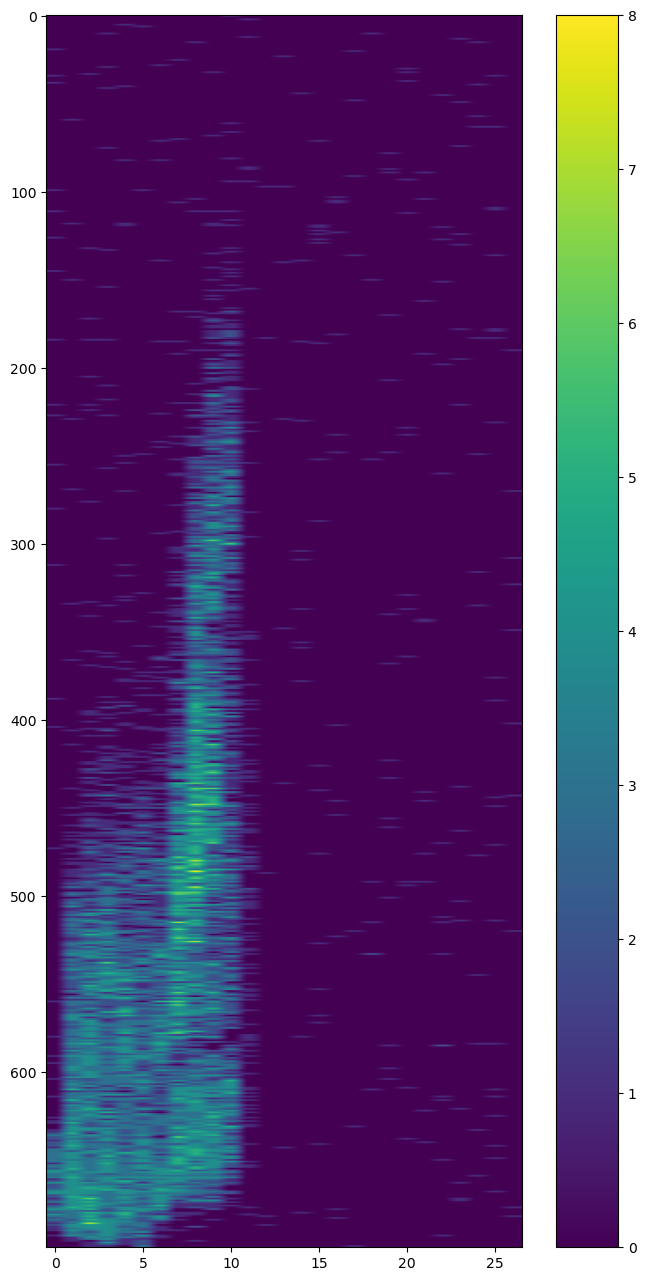

In [4]:
events, target = testset[10]
print(events.shape, target) # => shape is (27, 1, 700) -> 27 30ms events on 700 channels
print(events[10])

# plot channel x time heatmap where color represents spike count, time is 27 and channel is 700
# don't squeeze the time dimension
# since the y axis is 700 channels, make sure the plot is sized correctly -> a 16:9 aspect ratio is good
plt.figure(figsize=(9,16))

plt.imshow(events.T.squeeze())
# shrink the height increase the width of the plot
plt.gca().set_aspect(0.1, adjustable='box')

# add a colorbar
plt.colorbar()
plt.show()


(8913,) ('t', 'x', 'p') 16


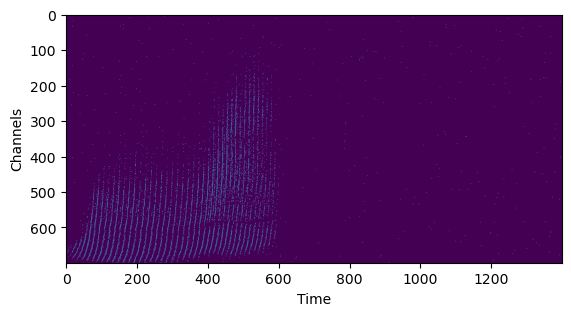

In [29]:
shd = tonic.datasets.SHD("./tutorials/data", train=False)
audio_events, label = shd[10]
print(audio_events.shape, audio_events.dtype.names, label)

tonic.utils.plot_event_grid(audio_events)

In [5]:
from torch.utils.data import DataLoader

def find_max_length(trainset):
    max_length = 0
    for i, (events, target) in enumerate(trainset):
        if events.shape[0] > max_length:
            max_length = events.shape[0]
    return max_length

# Find maximum length in the training set
max_seq_length = find_max_length(trainset)

print(f"Max sequence length: {max_seq_length}")


Max sequence length: 34


In [6]:
from torch.nn.utils.rnn import pad_sequence
import torch

def custom_collate_fn(batch):
    # Separate data and targets from the batch
    data, targets = zip(*batch)
    # Convert numpy arrays to tensors
    data = [torch.from_numpy(sequence) if isinstance(sequence, np.ndarray) else sequence for sequence in data]
    # Pad data sequences to max_seq_length
    padded_data = pad_sequence(data, batch_first=False, padding_value=0)  # Assuming 0 is an appropriate padding value
    if padded_data.size(0) < max_seq_length:
        # If the longest sequence in this batch is less than max_seq_length, pad additionally
        padding_size = max_seq_length - padded_data.size(0)
        padding = torch.zeros(padding_size, *padded_data.shape[1:], dtype=padded_data.dtype)
        padded_data = torch.cat([padded_data, padding], dim=0)
    return padded_data.to(torch.float32), torch.tensor(targets)



In [7]:
# !rm -r cache
from tonic import DiskCachedDataset
from torch.utils.data import DataLoader

batch_size = 64
shd_trainset = DiskCachedDataset(trainset, cache_path='./cache/shd/train')
shd_testset = DiskCachedDataset(testset, cache_path='./cache/shd/test')
# train_loader = DataLoader(shd_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=False, drop_last=True)
# test_loader = DataLoader(shd_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=False, drop_last=True)
# Now create the DataLoader using this new collate function
train_loader = DataLoader(shd_trainset, batch_size=batch_size, collate_fn=custom_collate_fn, shuffle=False, drop_last=True)
test_loader = DataLoader(shd_testset, batch_size=batch_size, collate_fn=custom_collate_fn, shuffle=False, drop_last=True)



In [8]:
# print size of train and test sets
len(shd_trainset), len(shd_testset)

(8156, 2264)

In [9]:
for i, (data, labels) in enumerate(train_loader):
    print(data.shape)

torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34, 64, 1, 700])
torch.Size([34

In [10]:
# for data, labels in iter(train_loader):
#     print(data.size())
    # print(len(labels))

# assert that the first dimension of all data batches is the same

for i, (data, labels) in enumerate(test_loader):
    print(i, data.size(), len(labels))
    assert data.size(0) == 34
    assert len(labels) == 64
        
    

0 torch.Size([34, 64, 1, 700]) 64
1 torch.Size([34, 64, 1, 700]) 64
2 torch.Size([34, 64, 1, 700]) 64
3 torch.Size([34, 64, 1, 700]) 64
4 torch.Size([34, 64, 1, 700]) 64
5 torch.Size([34, 64, 1, 700]) 64
6 torch.Size([34, 64, 1, 700]) 64
7 torch.Size([34, 64, 1, 700]) 64
8 torch.Size([34, 64, 1, 700]) 64
9 torch.Size([34, 64, 1, 700]) 64
10 torch.Size([34, 64, 1, 700]) 64
11 torch.Size([34, 64, 1, 700]) 64
12 torch.Size([34, 64, 1, 700]) 64
13 torch.Size([34, 64, 1, 700]) 64
14 torch.Size([34, 64, 1, 700]) 64
15 torch.Size([34, 64, 1, 700]) 64
16 torch.Size([34, 64, 1, 700]) 64
17 torch.Size([34, 64, 1, 700]) 64
18 torch.Size([34, 64, 1, 700]) 64
19 torch.Size([34, 64, 1, 700]) 64
20 torch.Size([34, 64, 1, 700]) 64
21 torch.Size([34, 64, 1, 700]) 64
22 torch.Size([34, 64, 1, 700]) 64
23 torch.Size([34, 64, 1, 700]) 64
24 torch.Size([34, 64, 1, 700]) 64
25 torch.Size([34, 64, 1, 700]) 64
26 torch.Size([34, 64, 1, 700]) 64
27 torch.Size([34, 64, 1, 700]) 64
28 torch.Size([34, 64, 1, 700]

In [11]:
# Training Parameters
num_classes = 20  # MNIST has 10 output classes
# device = "cuda"
device = "cpu"

# Torch Variables
dtype = torch.float

# # Torch Variables
# dtype = torch.float

# from torchvision import datasets, transforms

# # Define a transform
# transform = transforms.Compose([
#             transforms.Resize((28,28)),
#             transforms.Grayscale(),
#             transforms.ToTensor(),
#             transforms.Normalize((0,), (1,))
# ])

# mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
# mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# from torch.utils.data import DataLoader

# train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=False, drop_last=True)
# test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, drop_last=True)

In [64]:
num_steps = 28
bits = num_steps
# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

class replaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, x_r):
        return x_r

    @staticmethod
    def backward(ctx, grad):
        return (grad, grad)

# Helpers

In [90]:
# Accuracy Metric via rate coding

def calc_preds(output):
    # net.eval()
    # output, _ = net(data)
    # print('out', output.shape)
    # print('out sum', output.sum(dim=0).shape)
    # _, idx = output.sum(dim=0).max(1) 
    _, idx = output.sum(dim=0).squeeze().max(1)
    return idx

def print_batch_accuracy(output, targets, train=False, return_acc=False):
    idx = calc_preds(output)
    # log spike counts for each trial
    print('out spk counts', output.sum(dim=0))
    print("target shape, idx shape", targets.shape, idx.shape)
    # print('class pred', idx)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
        if return_acc:
            return acc
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")
        if return_acc:
            return acc

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(spk_rec, targets, train=True)
    print_batch_accuracy(test_spk, test_targets, train=False)
    print("\n")

def mean_max_grad(named_parameters):
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        # print(n, p.requires_grad)
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    
    return ave_grads, max_grads, layers

def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads, max_grads, layers = mean_max_grad(named_parameters)

    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    # plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    # save figure with iter
    # plt.savefig(f'./trainfigs/sanity_{counter}.png')
    plt.show()
    return ave_grads, max_grads


In [91]:
def avg_loss_plot(name='loss_curve0.png'):
    # plot per epoch average loss, x axis is number of epochs
    avg_loss_hist = []
    avg_test_loss_hist = []
    for i in range(0, len(loss_hist), len(train_loader)):
        avg_loss_hist.append(np.mean(loss_hist[i:i+len(train_loader)]))
        avg_test_loss_hist.append(np.mean(test_loss_hist[i:i+len(train_loader)]))

    fig = plt.figure(facecolor="w", figsize=(10, 5))
    plt.plot(avg_loss_hist)
    plt.plot(avg_test_loss_hist)
    plt.title("Loss Curves")
    plt.legend(["Train Loss", "Test Loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    # save the fig
    fig.savefig(f'./trainfigs/{name}')

In [92]:
# evaluate on full test set
def test_accuracy(data, targets):
    output, _ = net(data)
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())
    return acc

def total_accuracy():
    with torch.no_grad():
        net.eval()
        acc_hist = []
        for test_data, test_targets in test_loader:
            test_data = test_data.to(torch.float32).squeeze()
            test_acc = test_accuracy(test_data, test_targets)
            print(f"Test set accuracy for a single minibatch: {test_acc*100:.2f}%")
            acc_hist.append(test_acc)
        print(f"Final Test set accuracy: {np.mean(acc_hist)*100:.2f}%")


In [93]:
def activity_vis():
    # Visualize the neurons with a test example 
    with torch.no_grad():
        net.eval()
        test_data, test_targets = next(iter(test_loader))
        x = test_data.to(torch.float32).squeeze()[:, 0, :]
        y = test_targets[0]

        x_numpy = x.numpy()
        print(x_numpy.shape)

        net.plot_layer(x.numpy().T, title="Input spikes (activation) values of neurons")
        net.visualize_all_neurons(x) 
        # output neuron of label
        net.visualize_neuron(x, 1, y)

        # output neuron of incorrect label
        net.visualize_neuron(x, 1, 1-y)

        # save all open figs

# Custom Forward Grad and Traces 

In [65]:
# Custom Forward Grad and Traces 

# Network Architecture 
num_inputs = 700
num_hidden = 300
num_outputs = 20

# Temporal Dynamics
beta = 1 # no decay, IF neurons

# spike_grad = surrogate.fast_sigmoid()
spike_grad = None # -> defaults to ATan

# Define Network
class Net(nn.Module):
    def __init__(self, singleSpk=False):
        super().__init__()
        self.singleSpk = singleSpk
        if singleSpk:
            reset = "none" # -> no reset
        else:
            reset = "subtract"
        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, learn_beta=0, spike_grad=spike_grad, reset_mechanism=reset)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, learn_beta=0, spike_grad=spike_grad, reset_mechanism=reset)
            
        self.hasFired1 = torch.zeros(batch_size, num_hidden).to(device)
        self.hasFired2 = torch.zeros(batch_size, num_outputs).to(device)
        
#         self.decay = nn.parameter.Parameter(torch.ones(num_hidden))

    def clearState(self):
        self.mem1 = self.lif1.init_leaky()
        self.mem2 = self.lif2.init_leaky()
        self.hasFired1 = torch.zeros_like(self.hasFired1)
        self.hasFired2 = torch.zeros_like(self.hasFired2)
        # self.traces0 = torch.zeros(batch_size, 700).cuda()
        # self.traces1 = torch.zeros(batch_size, 300).cuda()
        self.traces0 = torch.zeros(batch_size, 700)
        self.traces1 = torch.zeros(batch_size, 300)

    def trackTrace(self, traces, spk):
        with torch.no_grad():
            traces = traces * beta + spk # -> when beta=1, this is just a running sum
        return traces


    def forward(self, x, targets, timestep=1):        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(timestep):
            spk = x[step].flatten(1)
            cur1 = self.fc1(spk)
            spk1, _ = self.lif1(cur1, self.mem1)
            if self.singleSpk:
                spk1 *= (1 - self.hasFired1)
                with torch.no_grad():
                    self.hasFired1 = torch.max(self.hasFired1, spk1)
            
#             if self.singleSpk:
#                 spk1 *= (1 - self.hasFired1)
#                 self.hasFired1 = torch.max(self.hasFired1, spk1)
            
            with torch.no_grad():
                self.traces1 = self.trackTrace(self.traces1, spk1)
                cur2 = self.fc2(spk1).detach()
            in_for_grad1 = replaceGrad.apply(spk1, self.traces1)
            out_for_grad1 = self.fc2(in_for_grad1)
            newCur2 = replaceGrad.apply(out_for_grad1, cur2)    
            spk2, self.mem2 = self.lif1(newCur2, self.mem2)
            
            
            
#             cur2 = self.fc2(spk1)
#             spk2, self.mem2 = self.lif2(cur2, self.mem2)
            
#             if self.singleSpk:
#                 spk2 *= (1 - self.hasFired2)
#                 self.hasFired2 = torch.max(self.hasFired2, spk2)

            spk2_rec.append(spk2)
            mem2_rec.append(newCur2)
#             print(cur1.shape, mem1.shape, cur2.shape, mem2.shape)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Trad SNN

In [272]:
# Net Architecture

n_inputs = events.shape[-1]
n_hidden = [300]
n_outputs = len(trainset.classes)

print(n_inputs, n_hidden, n_outputs)

# Temporal Dynamics

beta = 0.9
n_steps = next(iter(train_loader))[0].shape[0]
print(n_steps)

# surrogate grad 
sg = surrogate.fast_sigmoid()

700 [300] 20
34


In [303]:
# Define network 
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc_list = nn.ModuleList()
        self.lif_list = nn.ModuleList()

        fc_in = nn.Linear(n_inputs, n_hidden[0])
        self.fc_list.append(fc_in)
        lif_in = snn.Leaky(beta=beta, spike_grad=sg)
        self.lif_list.append(lif_in)

        for i in range(1, len(n_hidden)):
            fc = nn.Linear(n_hidden[i-1], n_hidden[i])
            self.fc_list.append(fc)
            lif = snn.Leaky(beta=beta, spike_grad=sg)
            self.lif_list.append(lif) 
        
        fc_out = nn.Linear(n_hidden[-1], n_outputs)
        self.fc_list.append(fc_out)
        lif_out = snn.Leaky(beta=beta, spike_grad=sg)
        self.lif_list.append(lif_out)
            
        # # Init layers
        # self.fc1 = nn.Linear(n_inputs, n_hidden)

        # self.lif1 = snn.Leaky(beta=beta, spike_grad=sg) # same as ReLU

        # self.fc2 = nn.Linear(n_hidden, n_outputs)
        # self.lif2 = snn.Leaky(beta=beta, spike_grad=sg)

    def forward(self, x):
        # Init hidden states at t=0
        # mem1 = self.lif1.init_leaky()
        # mem2 = self.lif2.init_leaky()
        mem_list = [lif.init_leaky() for lif in self.lif_list]

        # Record the final layer 
        # spk2_rec = []
        # mem2_rec = []
        spk_rec = []
        mem_rec = []

        # for step in range(n_steps):
        #     cur1 = self.fc1(x[step])
        #     spk1, mem1 = self.lif1(cur1, mem1)
            
        #     cur2 = self.fc2(spk1)
        #     spk2, mem2 = self.lif2(cur2, mem2)

        #     spk2_rec.append(spk2)
        #     mem2_rec.append(mem2)

        for step in range(n_steps):
            cur = x[step]
            for i, (fc, lif) in enumerate(zip(self.fc_list, self.lif_list)):
                cur = fc(cur)
                spk, mem = lif(cur, mem_list[i])
                mem_list[i] = mem
                cur = spk # -> pass spikes to next layer
            spk_rec.append(spk) # -> record the final layer
            mem_rec.append(mem)

        return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)

    def forward_with_rec(self, x):
            # Init hidden states at t=0
        # mem1 = self.lif1.init_leaky()
        # mem2 = self.lif2.init_leaky()
        mem_list = [lif.init_leaky() for lif in self.lif_list]

        # Record layer activity
        # spk1_rec = []
        # mem1_rec = []
        # spk2_rec = []
        # mem2_rec = []
        spk_rec = [[] for _ in range(len(self.fc_list))]
        mem_rec = [[] for _ in range(len(self.fc_list))]

        # for step in range(n_steps):
        #     cur1 = self.fc1(x[step])
        #     spk1, mem1 = self.lif1(cur1, mem1)
            
        #     cur2 = self.fc2(spk1)
        #     spk2, mem2 = self.lif2(cur2, mem2)

        #     spk1_rec.append(spk1)
        #     mem1_rec.append(mem1)
        #     spk2_rec.append(spk2)
        #     mem2_rec.append(mem2)    
        for step in range(n_steps):
            cur = x[step]
            for i, (fc, lif) in enumerate(zip(self.fc_list, self.lif_list)):
                cur = fc(cur)
                spk, mem = lif(cur, mem_list[i])
                mem_list[i] = mem
                cur = spk # -> pass spikes to next layer
                spk_rec[i].append(spk)
                mem_rec[i].append(mem)
                
        # zip each recording list in spk and mem together as pairs
        rec_list = [
                [torch.stack(s_rec, dim=0), torch.stack(m_rec, dim=0)]
                for s_rec, m_rec in zip(spk_rec, mem_rec)
            ]
        
        return rec_list
    
    def visualize_all_neurons(self, x):
        # assert x.shape[0] == 1, (
        #     "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        layers_hist = self.forward_with_rec(x)
 
        for i, (layer_output, layer_state) in enumerate(layers_hist):
            layer_state, layer_output = layer_state.cpu().numpy().squeeze().transpose(), layer_output.cpu().numpy().squeeze().transpose()
 
            self.plot_layer(layer_state, title="Inner state values of neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))
 
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        # assert x.shape[0] == 1, (
        #     "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        layers_hist = self.forward_with_rec(x)
 
        # layer_state, layer_output = layers_hist[layer_idx]
        layer_state, layer_output = layers_hist[layer_idx][1].cpu().numpy().squeeze().transpose(), layers_hist[layer_idx][0].cpu().numpy().squeeze().transpose()
 
        self.plot_neuron(
            layer_state[neuron_idx], 
            title="Inner state values neuron {} of layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(
            layer_output[neuron_idx], 
            title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))
 
    def plot_layer(self, layer_values, title):
        """
        This function is derived from:
            https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition
        Which was released under the MIT License.
        """
        fig, ax = plt.subplots(figsize=(16, 4))
        im = ax.pcolormesh(layer_values, cmap='rainbow')
        plt.title(title)
        plt.colorbar(im, ax=ax)
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")

        # Set y-axis ticks to integer values
        if layer_values.shape[0] < 10:
            ticks = np.arange(0, layer_values.shape[0]+1, 1)
            ax.set_yticks(ticks)
        else:
            ticks = np.arange(0, layer_values.shape[0]+1, int(layer_values.shape[0]/10))
            ax.set_yticks(ticks)

        plt.show()
 
    def plot_neuron(self, neuron_through_time, title):
        plt.figure(figsize=(16, 4))
        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")

        # add the voltage threshold by accessing state_dict of the leaky neuron
        plt.axhline(y=1, color='r', linestyle='-')

        plt.show()
    


In [12]:
# Accuracy Metric via rate coding

def calc_preds(data):
    output, _ = net(data)
    # print('out', output.shape)
    # print('out sum', output.sum(dim=0).shape)
    # _, idx = output.sum(dim=0).max(1) 
    _, idx = output.sum(dim=0).squeeze().max(1)
    return output, idx

def print_batch_accuracy(data, targets, train=False, return_acc=False):
    output, idx = calc_preds(data)
    # log spike counts for each trial
    print('out spk counts', output.sum(dim=0))
    print(targets.shape, idx.shape)
    # print('class pred', idx)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
        if return_acc:
            return acc
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")
        if return_acc:
            return acc

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

def mean_max_grad(named_parameters):
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        # print(n, p.requires_grad)
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    
    return ave_grads, max_grads, layers

def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads, max_grads, layers = mean_max_grad(named_parameters)

    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    # plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    # save figure with iter
    # plt.savefig(f'./trainfigs/sanity_{counter}.png')
    plt.show()
    return ave_grads, max_grads


In [305]:
net = Net()

# Loss Definition: Cross Entropy

# loss = nn.CrossEntropyLoss()

# Loss Defnition: MSE Spike Counts 

# loss = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

# Loss Definition: CE Spike Counts

loss = SF.ce_count_loss()

# Loss Definition: Max Membrane Loss 

# loss = SF.ce_max_membrane_loss()

# Loss Definition: MSE Membrane Potential

# loss = SF.mse_membrane_loss()

# Optimizer: Adam 
lr = 5e-4
optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999))

In [298]:
def minibatch_overfit():
    # overfit a single minibatch
    # set a loss threshold
    loss_thr = 0
    epoch_thr = 10
    epoch_count = 0
    loss_hist = [np.inf]
    # pick a random batch from train_loader
    data, targets = next(iter(train_loader))
    # data = data.permute(1, 0, 2).to(torch.float32)
    acc = 0

    print(targets)

    while acc < 1 and loss_hist[-1] > loss_thr or epoch_count < epoch_thr:
        spk_rec, mem_rec = net(data.squeeze())
        # initialize the total loss value
        # loss_val = torch.zeros((1), dtype=torch.float32, device=device)
        # for step in range(n_steps):
        #     # print(mem_rec[step], targets)
        #     loss_val += loss(mem_rec[step], targets)

        # loss_hist.append(loss_val.item())

        print(spk_rec.size(), targets.size())

        # loss_val = loss(mem_rec, targets) # mem loss
        loss_val = loss(spk_rec, targets) # spike count loss
        loss_hist.append(loss_val.item())

        print(f"Training loss: {loss_val.item():.3f}")
        acc = print_batch_accuracy(data, targets, train=True, return_acc=True)

        # clear previously stored gradients
        optimizer.zero_grad()

        # calculate the gradients
        loss_val.backward()

        # plot gradients
        grad = mean_max_grad(net.named_parameters())
        print(grad)

        # weight update
        optimizer.step()
        
        epoch_count += 1
        print(f"Epoch {epoch_count} complete")

    return loss_hist

minibatch_loss_hist = minibatch_overfit()

tensor([11, 13,  5, 10,  1, 13,  4, 14,  6,  0, 11, 17,  5,  9, 12, 12,  5,  0,
        14,  5,  9,  5, 15, 15, 19, 12,  0, 14, 19,  9,  1, 11, 12, 16,  0, 16,
        11, 15, 13, 12,  2, 14,  6, 17,  9,  3,  4,  4,  3, 11, 15,  1,  3, 12,
         1,  5,  9,  1,  6, 11, 19,  1,  7,  6])
torch.Size([34, 64, 20]) torch.Size([64])
Training loss: 6.002
out spk counts tensor([[[ 1.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[11.,  0.,  0.,  ...,  1.,  0.,  0.]],

        [[ 3.,  0.,  0.,  ...,  1.,  0.,  0.]],

        ...,

        [[ 6.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 9.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 2.,  0.,  0.,  ...,  0.,  0.,  0.]]], grad_fn=<SumBackward1>)
torch.Size([64]) torch.Size([64])
Train set accuracy for a single minibatch: 4.69%
([tensor(0.0070), tensor(0.0717)], [tensor(0.1853), tensor(3.2730)], ['fc_list.0.weight', 'fc_list.1.weight'])
Epoch 1 complete
torch.Size([34, 64, 20]) torch.Size([64])
Training loss: 4.365
out spk counts tensor([[[0.

In [283]:
print("Epochs on minibatch required to overfit: ", len(minibatch_loss_hist))

Epochs on minibatch required to overfit:  465


In [306]:
num_epochs = 200
loss_hist = []
test_loss_hist = []
counter = 0
grad_hist = []
# wandb.watch(net, log_freq=50, log="all")
# monitor = snn.probe.GradInputMonitor(net, instance=snn.Leaky())

# Outer training loop
for epoch in range(num_epochs): # i.e. number of times to loop over the entire dataset
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.squeeze()


        # forward pass
        net.train()
        spk_rec, mem_rec = net(data) # try logging spk_rec to verify that the network is learning, add hidden layer history as well

        # initialize the loss & sum over time
        # loss_val = torch.zeros((1), dtype=torch.float32, device=device)
        # for step in range(n_steps):
        #     loss_val += loss(mem_rec[step], targets)

        loss_val = loss(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        if counter % 50 == 0:
            grad = mean_max_grad(net.named_parameters())
            print(grad)
            grad_hist.append(grad)
            # log grad from wandb
            # wandb.log({"grad": grad_hist})

        # net.fc1.grad[:, 0:312] = 0
        optimizer.step()

        # Store loss history for future plotting -> for every 8 trials that model sees
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.squeeze()

            if test_data.size(0) != n_steps:
                continue

            # Test set forward pass
            test_spk, test_mem = net(test_data)

            # Test set loss
            # test_loss = torch.zeros((1), dtype=torch.float32, device=device)
            # for step in range(n_steps):
            #     test_loss += loss(test_mem[step], test_targets)
            test_loss = loss(test_spk, test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1

([tensor(0.0105), tensor(0.0887)], [tensor(0.2265), tensor(4.5256)], ['fc_list.0.weight', 'fc_list.1.weight'])
Epoch 0, Iteration 0
Train Set Loss: 6.46
Test Set Loss: 5.48
out spk counts tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 6.],
        [0., 0., 0.,  ..., 0., 0., 2.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 3.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
torch.Size([64]) torch.Size([64])
Train set accuracy for a single minibatch: 12.50%
out spk counts tensor([[0., 0., 0.,  ..., 2., 0., 4.],
        [0., 0., 0.,  ..., 1., 0., 2.],
        [0., 0., 0.,  ..., 1., 0., 5.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [2., 0., 0.,  ..., 0., 0., 4.],
        [0., 0., 0.,  ..., 3., 0., 5.]])
torch.Size([64]) torch.Size([64])
Test set accuracy for a single minibatch: 4.69%


([tensor(0.0002), tensor(0.0035)], [tensor(0.0163), tensor(0.2238)], ['fc_list.0.weight', 'fc_list.1.weight'])
Epoch 0, I

KeyboardInterrupt: 

In [206]:
for i, (x, y) in enumerate(test_loader):
    print(i, x.shape, y.shape)
    spk_rec, mem_rec = net(x.squeeze())

0 torch.Size([34, 100, 1, 700]) torch.Size([100])
1 torch.Size([34, 100, 1, 700]) torch.Size([100])
2 torch.Size([34, 100, 1, 700]) torch.Size([100])
3 torch.Size([34, 100, 1, 700]) torch.Size([100])
4 torch.Size([34, 100, 1, 700]) torch.Size([100])
5 torch.Size([34, 100, 1, 700]) torch.Size([100])
6 torch.Size([33, 100, 1, 700]) torch.Size([100])


IndexError: index 33 is out of bounds for dimension 0 with size 33

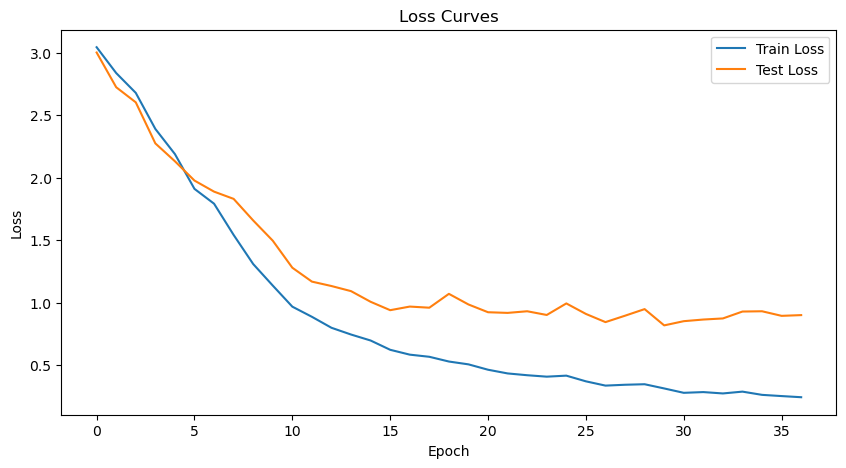

In [307]:
# plot per epoch average loss, x axis is number of epochs
avg_loss_hist = []
avg_test_loss_hist = []
for i in range(0, len(loss_hist), len(train_loader)):
    avg_loss_hist.append(np.mean(loss_hist[i:i+len(train_loader)]))
    avg_test_loss_hist.append(np.mean(test_loss_hist[i:i+len(train_loader)]))

fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(avg_loss_hist)
plt.plot(avg_test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# save the fig
fig.savefig('./trainfigs/loss_curve0.png')

In [308]:
# evaluate on full test set
def test_accuracy(data, targets):
    output, _ = net(data)
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())
    return acc

with torch.no_grad():
    net.eval()
    acc_hist = []
    for test_data, test_targets in test_loader:
        test_data = test_data.to(torch.float32).squeeze()
        test_acc = test_accuracy(test_data, test_targets)
        print(f"Test set accuracy for a single minibatch: {test_acc*100:.2f}%")
        acc_hist.append(test_acc)
    print(f"Final Test set accuracy: {np.mean(acc_hist)*100:.2f}%")


Test set accuracy for a single minibatch: 70.31%
Test set accuracy for a single minibatch: 70.31%
Test set accuracy for a single minibatch: 56.25%
Test set accuracy for a single minibatch: 60.94%
Test set accuracy for a single minibatch: 68.75%
Test set accuracy for a single minibatch: 78.12%
Test set accuracy for a single minibatch: 67.19%
Test set accuracy for a single minibatch: 68.75%
Test set accuracy for a single minibatch: 70.31%
Test set accuracy for a single minibatch: 71.88%
Test set accuracy for a single minibatch: 70.31%
Test set accuracy for a single minibatch: 62.50%
Test set accuracy for a single minibatch: 64.06%
Test set accuracy for a single minibatch: 70.31%
Test set accuracy for a single minibatch: 73.44%
Test set accuracy for a single minibatch: 71.88%
Test set accuracy for a single minibatch: 70.31%
Test set accuracy for a single minibatch: 71.88%
Test set accuracy for a single minibatch: 70.31%
Test set accuracy for a single minibatch: 68.75%
Test set accuracy fo

(34, 700)


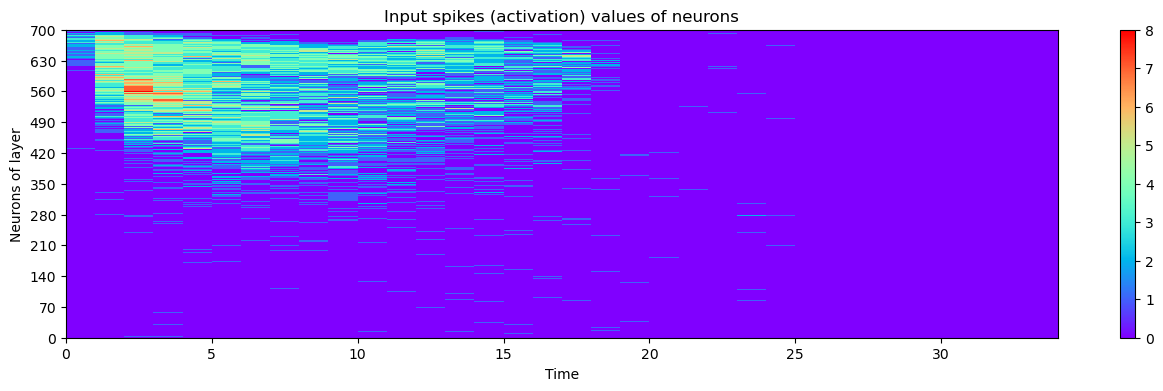

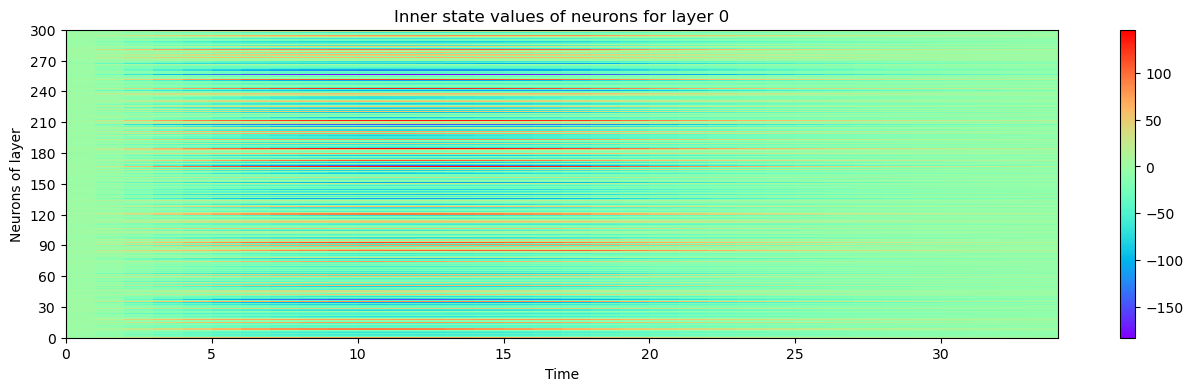

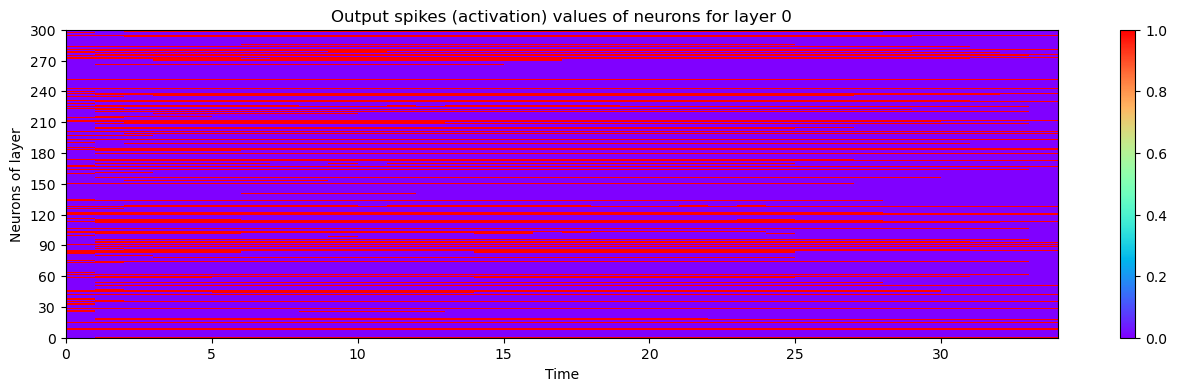

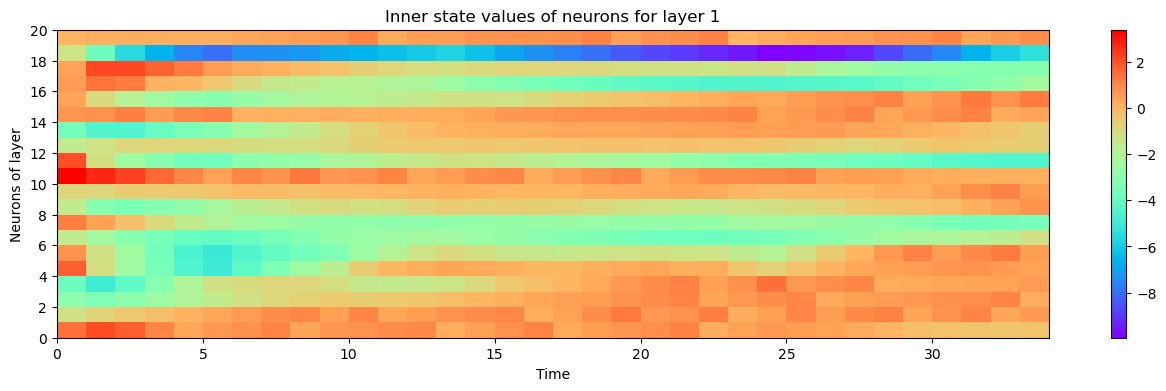

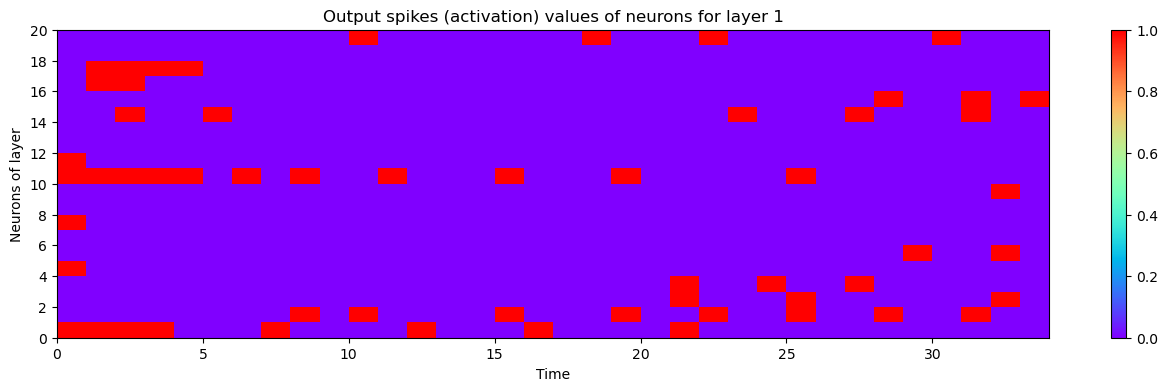

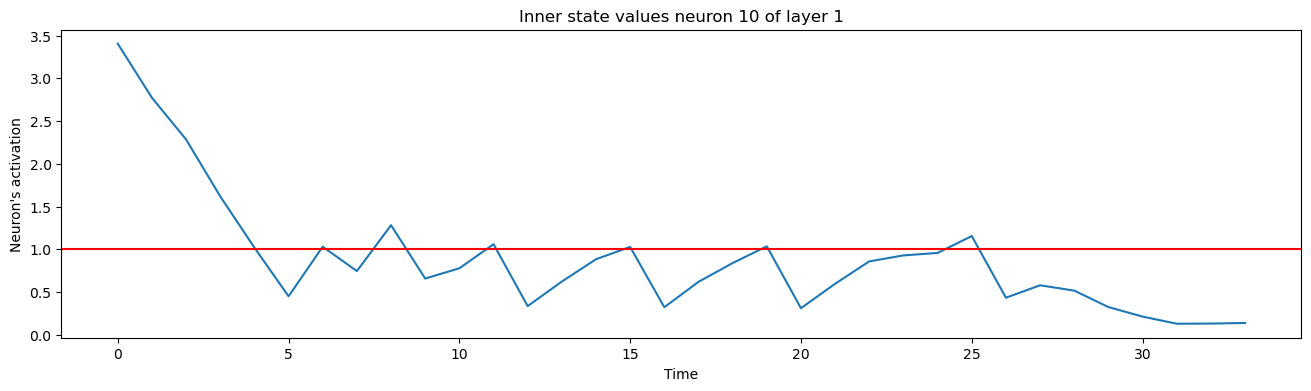

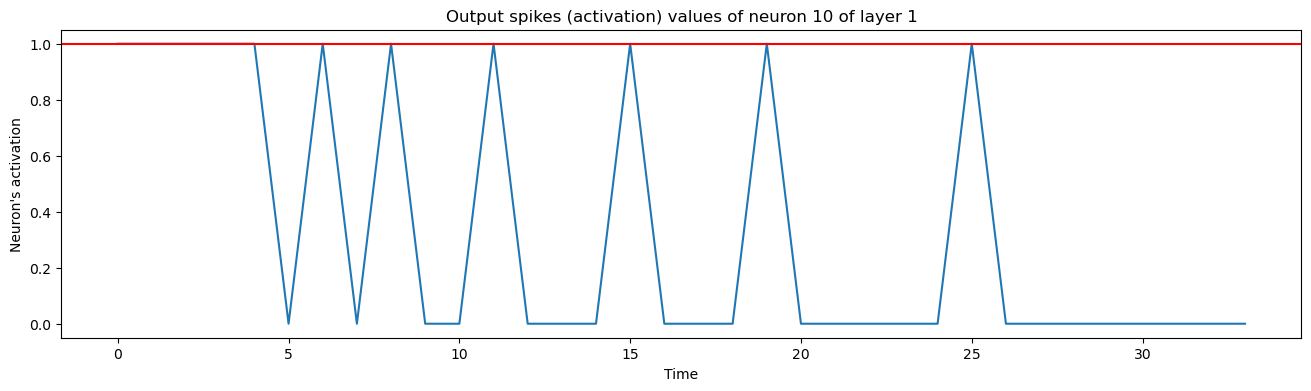

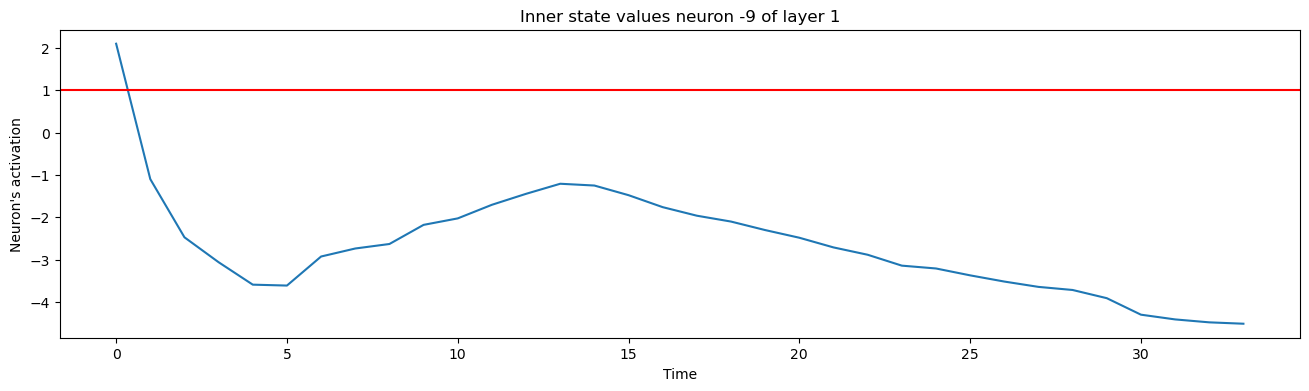

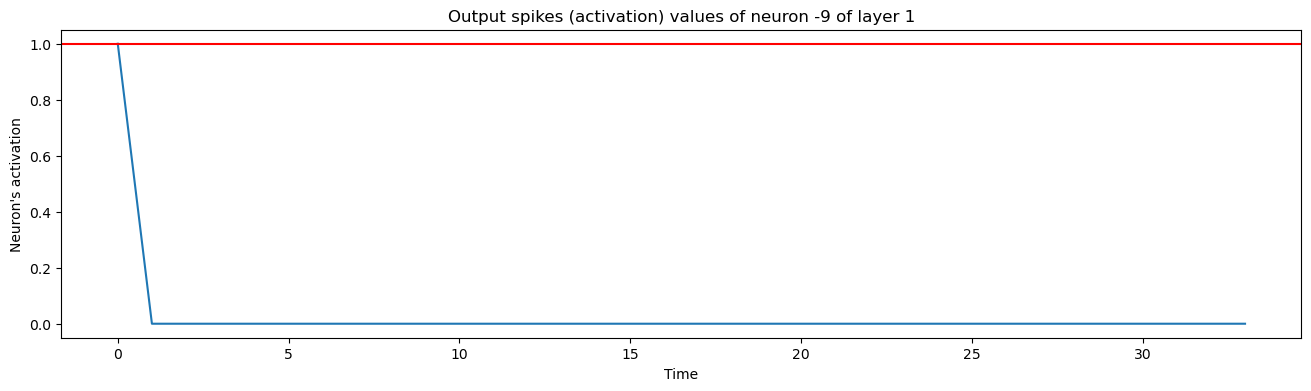

In [311]:
# Visualize the neurons with a test example 
with torch.no_grad():
    net.eval()
    test_data, test_targets = next(iter(test_loader))
    x = test_data.to(torch.float32).squeeze()[:, 0, :]
    y = test_targets[0]

    x_numpy = x.numpy()
    print(x_numpy.shape)

    net.plot_layer(x.numpy().T, title="Input spikes (activation) values of neurons")
    net.visualize_all_neurons(x) 
    # output neuron of label
    net.visualize_neuron(x, 1, y)

    # output neuron of incorrect label
    net.visualize_neuron(x, 1, 1-y)

    # save all open figs

# Single Spike BPTT -> spike count output

In [15]:
# Net Architecture

n_inputs = events.shape[-1]
n_hidden = [300]
n_outputs = len(trainset.classes)

print(n_inputs, n_hidden, n_outputs)

# Temporal Dynamics

beta = 1
n_steps = next(iter(train_loader))[0].shape[0]
print(n_steps)

# surrogate grad 
sg = surrogate.fast_sigmoid()

700 [300] 20
34


In [78]:
# Define network 
class SingleSpikeNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc_list = nn.ModuleList()
        self.lif_list = nn.ModuleList()

        fc_in = nn.Linear(n_inputs, n_hidden[0])
        self.fc_list.append(fc_in)
        lif_in = snn.Leaky(beta=beta, spike_grad=sg, reset_mechanism="none")
        self.lif_list.append(lif_in)

        for i in range(1, len(n_hidden)): # if theres a single hidden layer, this loop won't run
            fc = nn.Linear(n_hidden[i-1], n_hidden[i])
            self.fc_list.append(fc)
            lif = snn.Leaky(beta=beta, spike_grad=sg, reset_mechanism="none")
            self.lif_list.append(lif) 
        
        fc_out = nn.Linear(n_hidden[-1], n_outputs)
        self.fc_list.append(fc_out)
        lif_out = snn.Leaky(beta=beta, spike_grad=sg, reset_mechanism="none")
        self.lif_list.append(lif_out)

        # spikedState tensors 
        self.spikedStates = [torch.zeros(batch_size, hid_dim) for hid_dim in n_hidden]
        self.spikedStates.append(torch.zeros(batch_size, n_outputs))
        

    def forward(self, x):
        # init at t=0
        mem_list = [lif.init_leaky() for lif in self.lif_list]
        self.spikedStates = [torch.zeros_like(stateTensor) for stateTensor in self.spikedStates]

        # Record the final layer 

        spk_rec = []
        mem_rec = []

        # for step in range(n_steps):

        for step in range(n_steps):
            cur = x[step]
            for i, (fc, lif) in enumerate(zip(self.fc_list, self.lif_list)):
                cur = fc(cur)
                # print(cur.shape)
                spk, mem = lif(cur, mem_list[i])
                # print(spk.shape, self.spikedStates[i].shape)
                spk = spk * (1 - self.spikedStates[i])
                with torch.no_grad():
                    # set the spiked state to 1 if the neuron has spiked
                    self.spikedStates[i] = torch.max(self.spikedStates[i], spk)
                mem_list[i] = mem
                cur = spk # -> pass spikes to next layer
            spk_rec.append(spk) # -> record the final layer
            mem_rec.append(mem)

        return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)

    def forward_with_rec(self, x):
            # Init hidden states at t=0
        mem_list = [lif.init_leaky() for lif in self.lif_list]
        self.spikedStates = [torch.zeros_like(stateTensor) for stateTensor in self.spikedStates]

        # Record layer activity
        spk_rec = [[] for _ in range(len(self.fc_list))]
        mem_rec = [[] for _ in range(len(self.fc_list))]
  
        for step in range(n_steps):
            cur = x[step]
            for i, (fc, lif) in enumerate(zip(self.fc_list, self.lif_list)):
                cur = fc(cur)
                spk, mem = lif(cur, mem_list[i])
                spk = spk * (1 - self.spikedStates[i])
                with torch.no_grad():
                    # set the spiked state to 1 if the neuron has spiked
                    self.spikedStates[i] = torch.max(self.spikedStates[i], spk)
                mem_list[i] = mem
                cur = spk # -> pass spikes to next layer
                spk_rec[i].append(spk)
                mem_rec[i].append(mem)
                
        # zip each recording list in spk and mem together as pairs
        rec_list = [
                [torch.stack(s_rec, dim=0), torch.stack(m_rec, dim=0)]
                for s_rec, m_rec in zip(spk_rec, mem_rec)
            ]
        
        return rec_list
    
    def visualize_all_neurons(self, x):
        # assert x.shape[0] == 1, (
        #     "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        layers_hist = self.forward_with_rec(x)
 
        for i, (layer_output, layer_state) in enumerate(layers_hist):
            layer_state, layer_output = layer_state.cpu().numpy().squeeze().transpose(), layer_output.cpu().numpy().squeeze().transpose()
 
            self.plot_layer(layer_state, title="Inner state values of neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))
 
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        # assert x.shape[0] == 1, (
        #     "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        layers_hist = self.forward_with_rec(x)
 
        # layer_state, layer_output = layers_hist[layer_idx]
        layer_state, layer_output = layers_hist[layer_idx][1].cpu().numpy().squeeze().transpose(), layers_hist[layer_idx][0].cpu().numpy().squeeze().transpose()
 
        self.plot_neuron(
            layer_state[neuron_idx], 
            title="Inner state values neuron {} of layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(
            layer_output[neuron_idx], 
            title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))
 
    def plot_layer(self, layer_values, title):
        """
        This function is derived from:
            https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition
        Which was released under the MIT License.
        """
        fig, ax = plt.subplots(figsize=(16, 4))
        im = ax.pcolormesh(layer_values, cmap='rainbow')
        plt.title(title)
        plt.colorbar(im, ax=ax)
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")

        # Set y-axis ticks to integer values
        if layer_values.shape[0] < 10:
            ticks = np.arange(0, layer_values.shape[0]+1, 1)
            ax.set_yticks(ticks)
        else:
            ticks = np.arange(0, layer_values.shape[0]+1, int(layer_values.shape[0]/10))
            ax.set_yticks(ticks)

        plt.show()
 
    def plot_neuron(self, neuron_through_time, title):
        plt.figure(figsize=(16, 4))
        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")

        # add the voltage threshold by accessing state_dict of the leaky neuron
        plt.axhline(y=1, color='r', linestyle='-')

        plt.show()
    


In [86]:
# Accuracy Metric via rate coding

def calc_preds(output):
    # net.eval()
    # output, _ = net(data)
    # print('out', output.shape)
    # print('out sum', output.sum(dim=0).shape)
    # _, idx = output.sum(dim=0).max(1) 
    _, idx = output.sum(dim=0).squeeze().max(1)
    return idx

def print_batch_accuracy(output, targets, train=False, return_acc=False):
    idx = calc_preds(output)
    # log spike counts for each trial
    print('out spk counts', output.sum(dim=0))
    print("target shape, idx shape", targets.shape, idx.shape)
    # print('class pred', idx)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
        if return_acc:
            return acc
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")
        if return_acc:
            return acc

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(spk_rec, targets, train=True)
    print_batch_accuracy(test_spk, test_targets, train=False)
    print("\n")

def mean_max_grad(named_parameters):
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        # print(n, p.requires_grad)
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    
    return ave_grads, max_grads, layers

def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads, max_grads, layers = mean_max_grad(named_parameters)

    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    # plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    # save figure with iter
    # plt.savefig(f'./trainfigs/sanity_{counter}.png')
    plt.show()
    return ave_grads, max_grads


In [87]:
net = SingleSpikeNet()

# Loss Definition: Cross Entropy

# loss = nn.CrossEntropyLoss()

# Loss Defnition: MSE Spike Counts 

# loss = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

# Loss Definition: CE Spike Counts

loss = SF.ce_count_loss()

# Loss Definition: Max Membrane Loss 

# loss = SF.ce_max_membrane_loss()

# Loss Definition: MSE Membrane Potential

# loss = SF.mse_membrane_loss()

# Optimizer: Adam 
lr = 5e-4
optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999))

In [84]:
def minibatch_overfit():
    # overfit a single minibatch
    # set a loss threshold
    loss_thr = 0
    epoch_thr = 10
    epoch_count = 0
    loss_hist = [np.inf]
    # pick a random batch from train_loader
    data, targets = next(iter(train_loader))
    data = data.squeeze()
    # data = data.permute(1, 0, 2).to(torch.float32)
    acc = 0

    print("example targets", targets)

    while acc < 1 and loss_hist[-1] > loss_thr or epoch_count < epoch_thr:
        # net.train()
        spk_rec, mem_rec = net(data)
        # initialize the total loss value
        # loss_val = torch.zeros((1), dtype=torch.float32, device=device)
        # for step in range(n_steps):
        #     # print(mem_rec[step], targets)
        #     loss_val += loss(mem_rec[step], targets)

        # loss_hist.append(loss_val.item())

        print("spk size, target size", spk_rec.size(), targets.size())

        # loss_val = loss(mem_rec, targets) # mem loss
        loss_val = loss(spk_rec, targets) # spike count loss
        loss_hist.append(loss_val.item())

        print(f"Training loss: {loss_val.item():.3f}")
        acc = print_batch_accuracy(spk_rec, targets, train=True, return_acc=True)

        # clear previously stored gradients
        optimizer.zero_grad()

        # calculate the gradients
        loss_val.backward()

        # plot gradients
        grad = mean_max_grad(net.named_parameters())
        print("grad", grad)

        # weight update
        optimizer.step()
        
        epoch_count += 1
        print(f"Epoch {epoch_count} complete")

    return loss_hist

minibatch_loss_hist = minibatch_overfit()

example targets tensor([11, 13,  5, 10,  1, 13,  4, 14,  6,  0, 11, 17,  5,  9, 12, 12,  5,  0,
        14,  5,  9,  5, 15, 15, 19, 12,  0, 14, 19,  9,  1, 11, 12, 16,  0, 16,
        11, 15, 13, 12,  2, 14,  6, 17,  9,  3,  4,  4,  3, 11, 15,  1,  3, 12,
         1,  5,  9,  1,  6, 11, 19,  1,  7,  6])
spk size, target size torch.Size([34, 64, 20]) torch.Size([64])
Training loss: 3.143
out spk counts tensor([[0., 0., 1.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 1., 0.]], grad_fn=<SumBackward1>)
target shape, idx shape torch.Size([64]) torch.Size([64])
Train set accuracy for a single minibatch: 1.56%
grad ([tensor(0.0028), tensor(0.0159)], [tensor(0.0923), tensor(0.1222)], ['fc_list.0.weight', 'fc_list.1.weight'])
Epoch 1 complete
spk size, target size torch.Size([34, 64, 20]) torch.Size([64])
Training loss

KeyboardInterrupt: 

In [88]:
num_epochs = 200
loss_hist = []
test_loss_hist = []
counter = 0
grad_hist = []
# wandb.watch(net, log_freq=50, log="all")
# monitor = snn.probe.GradInputMonitor(net, instance=snn.Leaky())

# Outer training loop
for epoch in range(num_epochs): # i.e. number of times to loop over the entire dataset
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.squeeze()


        # forward pass
        net.train()
        spk_rec, mem_rec = net(data) # try logging spk_rec to verify that the network is learning, add hidden layer history as well

        # initialize the loss & sum over time
        # loss_val = torch.zeros((1), dtype=torch.float32, device=device)
        # for step in range(n_steps):
        #     loss_val += loss(mem_rec[step], targets)

        loss_val = loss(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        if counter % 50 == 0:
            grad = mean_max_grad(net.named_parameters())
            print(grad)
            grad_hist.append(grad)
            # log grad from wandb
            # wandb.log({"grad": grad_hist})

        # net.fc1.grad[:, 0:312] = 0
        optimizer.step()

        # Store loss history for future plotting -> for every 8 trials that model sees
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.squeeze()

            if test_data.size(0) != n_steps:
                continue

            # Test set forward pass
            test_spk, test_mem = net(test_data)

            # Test set loss
            # test_loss = torch.zeros((1), dtype=torch.float32, device=device)
            # for step in range(n_steps):
            #     test_loss += loss(test_mem[step], test_targets)
            test_loss = loss(test_spk, test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1

([tensor(0.0011), tensor(0.0047)], [tensor(0.0340), tensor(0.0950)], ['fc_list.0.weight', 'fc_list.1.weight'])
Epoch 0, Iteration 0
Train Set Loss: 3.08
Test Set Loss: 3.06
out spk counts tensor([[1., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.]])
target shape, idx shape torch.Size([64]) torch.Size([64])
Train set accuracy for a single minibatch: 6.25%
out spk counts tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])
target shape, idx shape torch.Size([64]) torch.Size([64])
Test set accuracy for a single minibatch: 4.69%


([tensor(0.0003), tensor(0.0030)], [tensor(0.0197), tensor(0.1084)], ['fc_

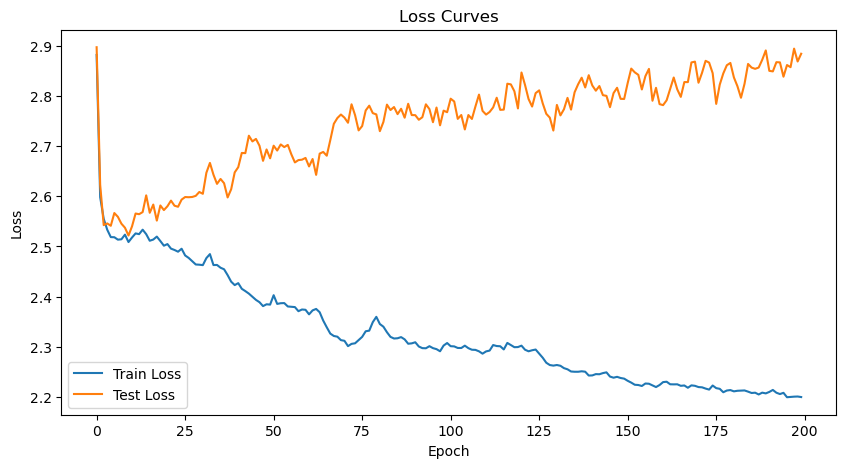

In [96]:
avg_loss_plot('single_spike_loss_curve0.png')

In [95]:
total_accuracy()

Test set accuracy for a single minibatch: 15.62%
Test set accuracy for a single minibatch: 12.50%
Test set accuracy for a single minibatch: 12.50%
Test set accuracy for a single minibatch: 12.50%
Test set accuracy for a single minibatch: 15.62%
Test set accuracy for a single minibatch: 15.62%
Test set accuracy for a single minibatch: 17.19%
Test set accuracy for a single minibatch: 12.50%
Test set accuracy for a single minibatch: 12.50%
Test set accuracy for a single minibatch: 14.06%
Test set accuracy for a single minibatch: 14.06%
Test set accuracy for a single minibatch: 12.50%
Test set accuracy for a single minibatch: 14.06%
Test set accuracy for a single minibatch: 10.94%
Test set accuracy for a single minibatch: 15.62%
Test set accuracy for a single minibatch: 12.50%
Test set accuracy for a single minibatch: 15.62%
Test set accuracy for a single minibatch: 18.75%
Test set accuracy for a single minibatch: 6.25%
Test set accuracy for a single minibatch: 14.06%
Test set accuracy for

(34, 700)


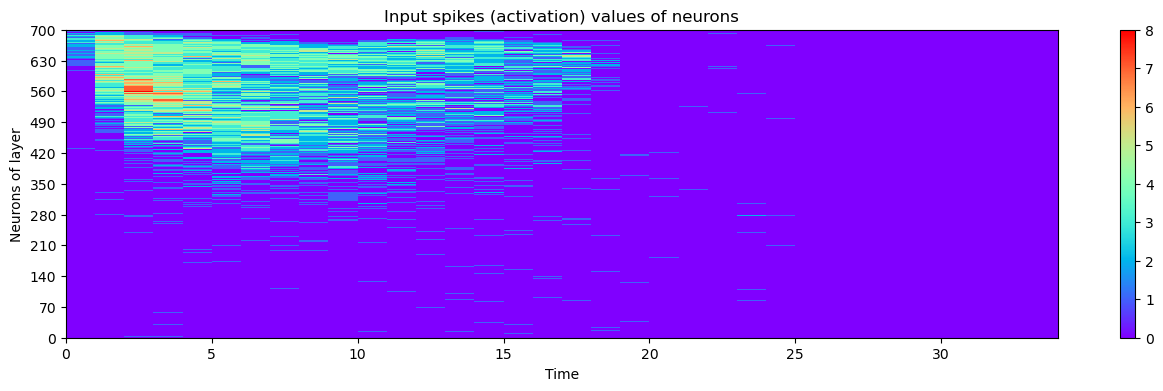

TypeError: list indices must be integers or slices, not tuple

In [97]:
activity_vis()

# Single Spike BPTT -> mem based output

In [101]:
# Net Architecture

n_inputs = events.shape[-1]
n_hidden = [300]
n_outputs = len(trainset.classes)

print(n_inputs, n_hidden, n_outputs)

# Temporal Dynamics

beta = 1
n_steps = next(iter(train_loader))[0].shape[0]
print(n_steps)

# surrogate grad 
sg = surrogate.fast_sigmoid()

700 [300] 20
34


In [102]:
# Define network 
class SingleSpikeNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc_list = nn.ModuleList()
        self.lif_list = nn.ModuleList()

        fc_in = nn.Linear(n_inputs, n_hidden[0])
        self.fc_list.append(fc_in)
        lif_in = snn.Leaky(beta=beta, spike_grad=sg, reset_mechanism="none")
        self.lif_list.append(lif_in)

        for i in range(1, len(n_hidden)): # if theres a single hidden layer, this loop won't run
            fc = nn.Linear(n_hidden[i-1], n_hidden[i])
            self.fc_list.append(fc)
            lif = snn.Leaky(beta=beta, spike_grad=sg, reset_mechanism="none")
            self.lif_list.append(lif) 
        
        fc_out = nn.Linear(n_hidden[-1], n_outputs)
        self.fc_list.append(fc_out)
        lif_out = snn.Leaky(beta=beta, spike_grad=sg, reset_mechanism="none")
        self.lif_list.append(lif_out)

        # spikedState tensors 
        self.spikedStates = [torch.zeros(batch_size, hid_dim) for hid_dim in n_hidden]
        self.spikedStates.append(torch.zeros(batch_size, n_outputs))
        

    def forward(self, x):
        # init at t=0
        mem_list = [lif.init_leaky() for lif in self.lif_list]
        self.spikedStates = [torch.zeros_like(stateTensor) for stateTensor in self.spikedStates]

        # Record the final layer 

        spk_rec = []
        mem_rec = []

        # for step in range(n_steps):

        for step in range(n_steps):
            cur = x[step]
            for i, (fc, lif) in enumerate(zip(self.fc_list, self.lif_list)):
                cur = fc(cur)
                # print(cur.shape)
                spk, mem = lif(cur, mem_list[i])
                # print(spk.shape, self.spikedStates[i].shape)
                spk = spk * (1 - self.spikedStates[i])
                with torch.no_grad():
                    # set the spiked state to 1 if the neuron has spiked
                    self.spikedStates[i] = torch.max(self.spikedStates[i], spk)
                mem_list[i] = mem
                cur = spk # -> pass spikes to next layer
            spk_rec.append(spk) # -> record the final layer
            mem_rec.append(mem)

        return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)

    def forward_with_rec(self, x):
            # Init hidden states at t=0
        mem_list = [lif.init_leaky() for lif in self.lif_list]
        self.spikedStates = [torch.zeros_like(stateTensor) for stateTensor in self.spikedStates]

        # Record layer activity
        spk_rec = [[] for _ in range(len(self.fc_list))]
        mem_rec = [[] for _ in range(len(self.fc_list))]
  
        for step in range(n_steps):
            cur = x[step]
            for i, (fc, lif) in enumerate(zip(self.fc_list, self.lif_list)):
                cur = fc(cur)
                spk, mem = lif(cur, mem_list[i])
                spk = spk * (1 - self.spikedStates[i])
                with torch.no_grad():
                    # set the spiked state to 1 if the neuron has spiked
                    self.spikedStates[i] = torch.max(self.spikedStates[i], spk)
                mem_list[i] = mem
                cur = spk # -> pass spikes to next layer
                spk_rec[i].append(spk)
                mem_rec[i].append(mem)
                
        # zip each recording list in spk and mem together as pairs
        rec_list = [
                [torch.stack(s_rec, dim=0), torch.stack(m_rec, dim=0)]
                for s_rec, m_rec in zip(spk_rec, mem_rec)
            ]
        
        return rec_list
    
    def visualize_all_neurons(self, x):
        # assert x.shape[0] == 1, (
        #     "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        layers_hist = self.forward_with_rec(x)
 
        for i, (layer_output, layer_state) in enumerate(layers_hist):
            layer_state, layer_output = layer_state.cpu().numpy().squeeze().transpose(), layer_output.cpu().numpy().squeeze().transpose()
 
            self.plot_layer(layer_state, title="Inner state values of neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))
 
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        # assert x.shape[0] == 1, (
        #     "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        layers_hist = self.forward_with_rec(x)
 
        # layer_state, layer_output = layers_hist[layer_idx]
        layer_state, layer_output = layers_hist[layer_idx][1].cpu().numpy().squeeze().transpose(), layers_hist[layer_idx][0].cpu().numpy().squeeze().transpose()
 
        self.plot_neuron(
            layer_state[neuron_idx], 
            title="Inner state values neuron {} of layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(
            layer_output[neuron_idx], 
            title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))
 
    def plot_layer(self, layer_values, title):
        """
        This function is derived from:
            https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition
        Which was released under the MIT License.
        """
        fig, ax = plt.subplots(figsize=(16, 4))
        im = ax.pcolormesh(layer_values, cmap='rainbow')
        plt.title(title)
        plt.colorbar(im, ax=ax)
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")

        # Set y-axis ticks to integer values
        if layer_values.shape[0] < 10:
            ticks = np.arange(0, layer_values.shape[0]+1, 1)
            ax.set_yticks(ticks)
        else:
            ticks = np.arange(0, layer_values.shape[0]+1, int(layer_values.shape[0]/10))
            ax.set_yticks(ticks)

        plt.show()
 
    def plot_neuron(self, neuron_through_time, title):
        plt.figure(figsize=(16, 4))
        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")

        # add the voltage threshold by accessing state_dict of the leaky neuron
        plt.axhline(y=1, color='r', linestyle='-')

        plt.show()
    


In [103]:
net = SingleSpikeNet()

# Loss Definition: Cross Entropy

loss = nn.CrossEntropyLoss()

# Loss Defnition: MSE Spike Counts 

# loss = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

# Loss Definition: CE Spike Counts

# loss = SF.ce_count_loss()

# Loss Definition: Max Membrane Loss 

# loss = SF.ce_max_membrane_loss()

# Loss Definition: MSE Membrane Potential

# loss = SF.mse_membrane_loss()

# Optimizer: Adam 
lr = 5e-4
optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999))

In [104]:
def minibatch_overfit():
    # overfit a single minibatch
    # set a loss threshold
    loss_thr = 0
    epoch_thr = 10
    epoch_count = 0
    loss_hist = [np.inf]
    # pick a random batch from train_loader
    data, targets = next(iter(train_loader))
    data = data.squeeze()
    # data = data.permute(1, 0, 2).to(torch.float32)
    acc = 0

    print("example targets", targets)

    while acc < 1 and loss_hist[-1] > loss_thr or epoch_count < epoch_thr:
        # net.train()
        spk_rec, mem_rec = net(data)

        print("spk size, target size", spk_rec.size(), targets.size())

        # initialize the total loss value
        # loss_val = torch.zeros((1), dtype=torch.float32, device=device)
        # for step in range(n_steps):
        #     # print(mem_rec[step], targets)
        #     loss_val += loss(mem_rec[step], targets)
        # loss_hist.append(loss_val.item())

        # loss_val = loss(mem_rec, targets) # mem loss
        # loss_val = loss(spk_rec, targets) # spike count loss

        # last mem state CE loss 
        loss_val = loss(mem_rec[-1], targets)

        loss_hist.append(loss_val.item())

        print(f"Training loss: {loss_val.item():.3f}")
        # acc = print_batch_accuracy(spk_rec, targets, train=True, return_acc=True)

        # clear previously stored gradients
        optimizer.zero_grad()

        # calculate the gradients
        loss_val.backward()

        # print accuracy based on mem_rec[-1] and targets
        pred = torch.argmax(mem_rec[-1], dim=1)
        acc = (pred == targets).float().mean()
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")

        # plot gradients
        grad = mean_max_grad(net.named_parameters())
        print("grad", grad)

        # weight update
        optimizer.step()
        
        epoch_count += 1
        print(f"Epoch {epoch_count} complete")

    return loss_hist

minibatch_loss_hist = minibatch_overfit()

example targets tensor([11, 13,  5, 10,  1, 13,  4, 14,  6,  0, 11, 17,  5,  9, 12, 12,  5,  0,
        14,  5,  9,  5, 15, 15, 19, 12,  0, 14, 19,  9,  1, 11, 12, 16,  0, 16,
        11, 15, 13, 12,  2, 14,  6, 17,  9,  3,  4,  4,  3, 11, 15,  1,  3, 12,
         1,  5,  9,  1,  6, 11, 19,  1,  7,  6])
spk size, target size torch.Size([34, 64, 20]) torch.Size([64])
Training loss: 3.565
Train set accuracy for a single minibatch: 6.25%
grad ([tensor(0.0036), tensor(0.0266)], [tensor(0.1189), tensor(0.1206)], ['fc_list.0.weight', 'fc_list.1.weight'])
Epoch 1 complete
spk size, target size torch.Size([34, 64, 20]) torch.Size([64])
Training loss: 3.217
Train set accuracy for a single minibatch: 7.81%
grad ([tensor(0.0036), tensor(0.0223)], [tensor(0.1774), tensor(0.0871)], ['fc_list.0.weight', 'fc_list.1.weight'])
Epoch 2 complete
spk size, target size torch.Size([34, 64, 20]) torch.Size([64])
Training loss: 2.970
Train set accuracy for a single minibatch: 17.19%
grad ([tensor(0.0028), ten

# zhengyu's version

In [315]:
# Single Spike BPTT

# Network Architecture
num_inputs = 700
num_hidden = 300
num_outputs = 20

# Temporal Dynamics
beta = 1
timestep = next(iter(train_loader))[0].shape[0]

# spike_grad = surrogate.fast_sigmoid()
spike_grad = None

# Define Network
class Net(nn.Module):
    def __init__(self, singleSpk=False):
        super().__init__()
        self.singleSpk = singleSpk
        if singleSpk:
            reset = "none"
        else:
            reset = "subtract"
        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, learn_beta=0, spike_grad=spike_grad, reset_mechanism=reset)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, learn_beta=0, spike_grad=spike_grad, reset_mechanism=reset)
            
        self.hasFired1 = torch.zeros(batch_size, num_hidden).to(device)
        self.hasFired2 = torch.zeros(batch_size, num_outputs).to(device)
        
#         self.decay = nn.parameter.Parameter(torch.ones(num_hidden))
    
    def clearState(self):
        self.mem1 = self.lif1.init_leaky()
        self.mem2 = self.lif2.init_leaky()
        self.hasFired1 = torch.zeros_like(self.hasFired1)
        self.hasFired2 = torch.zeros_like(self.hasFired2)

    # def forward(self, x, targets, timestep=1):       
    def forward(self, x): 
        # Record the final layer
        spk2_rec = []
        mem2_rec = []
        cur2_rec = []

        for step in range(timestep):
            # spk = x[step].flatten(1)
            spk = x[step]
            cur1 = self.fc1(spk)
            spk1, _ = self.lif1(cur1, self.mem1)
            if self.singleSpk:
                # spk1 *= (1 - self.hasFired1)
                spk1 = spk1 * (1 - self.hasFired1)
                with torch.no_grad():
                    self.hasFired1 = torch.max(self.hasFired1, spk1)
            cur2 = self.fc2(spk1)            
            spk2, self.mem2 = self.lif1(cur2, self.mem2)
            if self.singleSpk:
                # spk2 *= (1 - self.hasFired2)
                spk2 = spk2 * (1 - self.hasFired2)
                with torch.no_grad():
                    self.hasFired2 = torch.max(self.hasFired2, spk2)
            

#             cur1 = self.fc1(x[step].flatten(1))
#             spk1, self.mem1 = self.lif1(cur1, self.mem1)
            
# #             if self.singleSpk:
# #                 spk1 *= (1 - self.hasFired1)
# #                 self.hasFired1 = torch.max(self.hasFired1, spk1)
            
#             cur2 = self.fc2(spk1)
#             spk2, self.mem2 = self.lif2(cur2, self.mem2)
            
# #             if self.singleSpk:
# #                 spk2 *= (1 - self.hasFired2)
# #                 self.hasFired2 = torch.max(self.hasFired2, spk2)

            spk2_rec.append(spk2)
            mem2_rec.append(self.mem2)
            cur2_rec.append(cur2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0), torch.stack(cur2_rec, dim=0)

In [332]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target
import numpy as np

torch.manual_seed(7)
# Load the network onto CUDA if available
net = Net(singleSpk=1).to(device)
# net = Net(singleSpk=1)
   
loss = nn.CrossEntropyLoss() # -> need to change to spike count loss 
optimizer = torch.optim.Adam(net.parameters(), lr=17e-5, betas=(0.9, 0.999))

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=.5)

In [333]:
torch.manual_seed(7)
num_epochs = 100
loss_hist = []
test_loss_hist = []
counter = 0

for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        # data = data.to(device)
        data = data.squeeze()
        targets = targets.long()
        targets = targets.to(device)

        # forward pass
        net.train()
        net.clearState()
        # for t in range(data.shape[0]):
        #     spk_rec, mem_rec, cur_rec = net(data[t:t+1], targets)
        #     loss_val = loss(cur_rec[-1], targets)
        #     optimizer.zero_grad()
        #     loss_val.backward()
        #     optimizer.step()
        spk_rec, mem_rec, cur_rec = net(data)

        # one hot encode the targets
        # targets = torch.nn.functional.one_hot(targets, num_classes=20).float()

        loss_val = loss(cur_rec[-1], targets) # cur_rec stores the output of the last FC layer 
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

    scheduler.step()
    
    with torch.no_grad():
        net.eval()
        total = 0
        correct = 0
        test_loss = 0
        for data, targets in test_loader:
            # data = data.to(device)
            targets = targets.long()
            targets = targets.to(device)
            data = data.squeeze()

            # one_hot_targets = torch.nn.functional.one_hot(targets, num_classes=20).float()

            # print(data.shape, targets.shape)

            # forward pass
            net.clearState()
            test_spk, mem, _ = net(data)

            # print(test_spk.shape, mem.shape)

            # calculate total accuracy
#             _, predicted = test_spk.sum(dim=0).max(1)
            temp = test_spk.sum(0)
   #         temp = bin2dec(test_spk, bits, net.phase2)

            # current based output -> make sure this is correct
            memF = mem[-1].clone()
            # memF[temp!=temp.max(1)[0][:, None]] = float('-inf')
            # predicted = memF.max(-1)[1]
            predicted = memF.argmax(-1)
            # print(predicted.shape)

#             if not net.singleSpk:
#                 predicted = test_spk.sum(0).max(-1)[1]
#             _, predicted = bin2dec(test_spk, bits, net.phase2).max(1)
#             _, predicted = mem[-1].max(1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            # test_loss += loss(mem[-1], one_hot_targets)
            test_loss += loss(mem[-1], targets)

        test_loss_avg = test_loss / len(test_loader)
        test_loss_hist.append(test_loss_avg.item())
       
        print(f"Epoch {epoch}")
        print(f"Total correctly classified test set images: {correct}/{total}")
        print(f"Test Set Accuracy: {100 * correct / total:.2f}%")
        print(f"Test Set Loss: {test_loss_avg:.2f}\n")
        with open("shd2.txt", "a") as f:
            f.write(f"{epoch}: {100 * correct / total:.2f}%\n")
            f.write(f"Test Set Loss: {test_loss_avg:.2f}\n")

Epoch 0
Total correctly classified test set images: 103/2240
Test Set Accuracy: 4.60%
Test Set Loss: 3.87

Epoch 1
Total correctly classified test set images: 105/2240
Test Set Accuracy: 4.69%
Test Set Loss: 3.83

Epoch 2
Total correctly classified test set images: 101/2240
Test Set Accuracy: 4.51%
Test Set Loss: 3.79

Epoch 3
Total correctly classified test set images: 99/2240
Test Set Accuracy: 4.42%
Test Set Loss: 3.75

Epoch 4
Total correctly classified test set images: 106/2240
Test Set Accuracy: 4.73%
Test Set Loss: 3.72

Epoch 5
Total correctly classified test set images: 107/2240
Test Set Accuracy: 4.78%
Test Set Loss: 3.69

Epoch 6
Total correctly classified test set images: 105/2240
Test Set Accuracy: 4.69%
Test Set Loss: 3.66

Epoch 7
Total correctly classified test set images: 104/2240
Test Set Accuracy: 4.64%
Test Set Loss: 3.63

Epoch 8
Total correctly classified test set images: 102/2240
Test Set Accuracy: 4.55%
Test Set Loss: 3.60

Epoch 9
Total correctly classified tes

In [ ]:
spk_rec[-1].requires_grad

In [92]:
mem_rec[-1]

_SpikeTensor([])